In [1]:
from ever_crisis_gacha_simulator.classes.gacha_sim import GachaSim
from ever_crisis_gacha_simulator.banner_info_and_stamp_cards import AERITH_LUCIA_EASTER_BANNER, ZACK_SEPHIROTH_LIMIT_BREAK_BANNER
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk

plt.style.use("cyberpunk")

# Answering common "should you pull" questions via simulation

### For One Stamp Card (i.e., "I want this costume"):
1. How many crystals do I need? (more detail than just "Save 36,000 Crystals")
2. If I target one of the featured weapons, how many should I expect to get?
3. Looking at one of my wishlist weapons, how many should I expect to get?

### We'll ask the same questions for two stamp cards.
Maybe you want _both_ costumes!

In [2]:
def stamp_analysis_wrapper(criterion_stamp_value, target_weapon_type):
    """
    A wrapper around GachaSim instantiation for our stamp analysis. Returns a GachaSim object.
    """

    gs = GachaSim(
        session_criterion="stamps_earned",
        criterion_value=criterion_stamp_value,
        target_weapon_type=target_weapon_type,
        banner_info=AERITH_LUCIA_EASTER_BANNER,
        seed_value=1337,
        starting_weapon_parts=0,
        num_simulations=500_000,
    )

    return gs

stamp_analysis_inputs = {
    "one_card_featured": {
        "criterion_stamp_value": 12,
        "target_weapon_type": "featured",
    },
    "two_cards_featured": {
        "criterion_stamp_value": 24,
        "target_weapon_type": "featured",
    },
    "one_card_wishlisted": {
        "criterion_stamp_value": 12,
        "target_weapon_type": "wishlisted",
    },
    "two_cards_wishlisted": {
        "criterion_stamp_value": 24,
        "target_weapon_type": "wishlisted",
    },
}

In [3]:
def ob_analysis_wrapper(criterion_overboost_value):
    """
    A wrapper around GachaSim instantiation for our limit break overboost analysis. Returns a GachaSim object.
    """

    gs = GachaSim(
        session_criterion="overboost",
        criterion_value=criterion_overboost_value,
        target_weapon_type="featured",
        banner_info=ZACK_SEPHIROTH_LIMIT_BREAK_BANNER,
        seed_value=1337,
        starting_weapon_parts=0,
        num_simulations=500_000,
    )

    return gs

# A dictionary for only one input is a bit overkill, so I'll be skipping that step and just inputting
# the overboost value. 

In [4]:
# Set some parameters for viz_wrapper definition



In [26]:
def viz_wrapper(
    gs, 
    column,
    values=None,
    probs=None,
    ):

    if probs and values:
        print("ERROR: Values passed for both `probs` and `values`. Only pass values for one.")
        return
    
    ORB_HEX_CODES = ["#0093FF", "#CB00FF", "#FFC800"]
    MAX_X_TICKS = 15
    FONT_SIZE = 12
    
    if probs:
        colors = sns.blend_palette(colors=orb_hex_codes, n_colors=len(probs))
        colors.reverse()
    elif values:
        colors = sns.blend_palette(colors=orb_hex_codes, n_colors=len(values))
        colors.reverse()
    else:
        colors = None
    
    plot = gs.visualize_results(outcome=column)

    x_max = plot.ax.get_xlim()[1]
    
    if column == "num_crystals_spent":
        crystal_count_by = 3_000

        # Ensure adequate tick mark spacing for x-axis
        while x_max / crystal_count_by > MAX_X_TICKS:
            crystal_count_by += 3_000
        
        plot.ax.set_xticks(np.arange(0, x_max+1, crystal_count_by))
        plot.ax.set_xticklabels([f"{label:,.0f}" for label in plot.ax.get_xticks()])
        # plot.set_xticklabels(rotation=60)
    elif column == "targeted_weapon_parts":
        wpn_parts_count_by = 200

        while x_max / wpn_parts_count_by > MAX_X_TICKS:
            wpn_parts_count_by += 200
        
        plot.ax.set_xticks(np.arange(0, x_max+1, wpn_parts_count_by))
        plot.ax.set_xticklabels([f"{label:,.0f}" for label in plot.ax.get_xticks()])
        
    plot.set_xticklabels(rotation=45, fontsize=FONT_SIZE, fontweight='semibold')
    plot.ax.set_yticks(np.arange(0, 101, 10))
    plot.set_yticklabels(fontsize=FONT_SIZE, fontweight='semibold') 

    if probs:
        values = [int(np.percentile(gs.sim_results[column], prob)) for prob in probs]
    
    # Horizontal lines with labels for values of interest
    if values or probs:

        if column == "num_crystals_spent":
            legend_label = "Crystals"
        elif column == "targeted_weapon_parts":
            legend_label = "Overboost"
        else:
            legend_label == "Stamps"

        WEAPON_PARTS_TO_OVERBOOST = 200

        # if column != "targeted_weapon_parts":
        #     colors.reverse()
        
        for index, value in enumerate(sorted(values, reverse=True)):

            if column == "targeted_weapon_parts":
                converted_value = int(value / WEAPON_PARTS_TO_OVERBOOST - 1)
            
            value_prob = gs.return_value_probability(column=column, value=value)
            
            plot.ax.hlines(
                y=value_prob,
                linestyles="dashed",
                linewidth=2,
                xmin=0,
                xmax=x_max,
                color=colors[index],
                alpha=0.75,
                label=f"{value_prob}% ({value:,} {legend_label})" if column != "targeted_weapon_parts" else f"{value_prob}% ({legend_label} {converted_value})",
            )

        plot.ax.legend(
            title="Probability Lines", 
            prop={"weight": "semibold"}, 
            title_fontproperties={"weight": "semibold"}, 
            bbox_to_anchor=(1.50, 0.6)
            )

# One Stamp Card -- How many crystals?

- 21,000 crystals gives a >50% chance
- 24,000 crystals gives almost a 90% chance
- Nearly 100% chance at 27,000 crystals
- 18,000 or below is... sus.

In [7]:
one_card_featured = stamp_analysis_wrapper(**stamp_analysis_inputs["one_card_featured"])

one_card_featured.run_sims(n_jobs=-1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.95it/s]


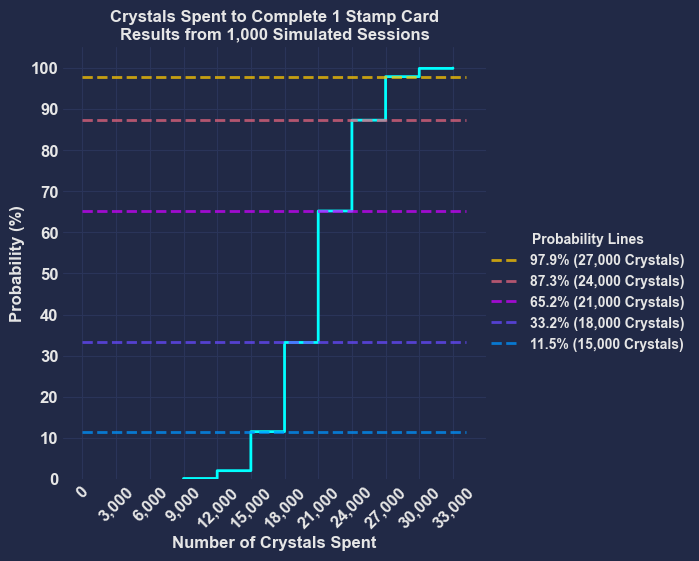

In [27]:
OUTCOME = "num_crystals_spent"
VALUES_OF_INTEREST = [15_000, 18_000, 21_000, 24_000, 27_000]

viz_wrapper(gs=one_card_featured, column=OUTCOME, values=VALUES_OF_INTEREST)

# One Stamp Card -- Targeted Featured Weapon Parts?

- Results assume that you have the targeted weapon guaranteed at stamp #6
- 50-50 shot for OB1 after one stamp card
- ... which means 50-50 of even getting a 5* of the other featured weapon
- Any higher is quite lucky!

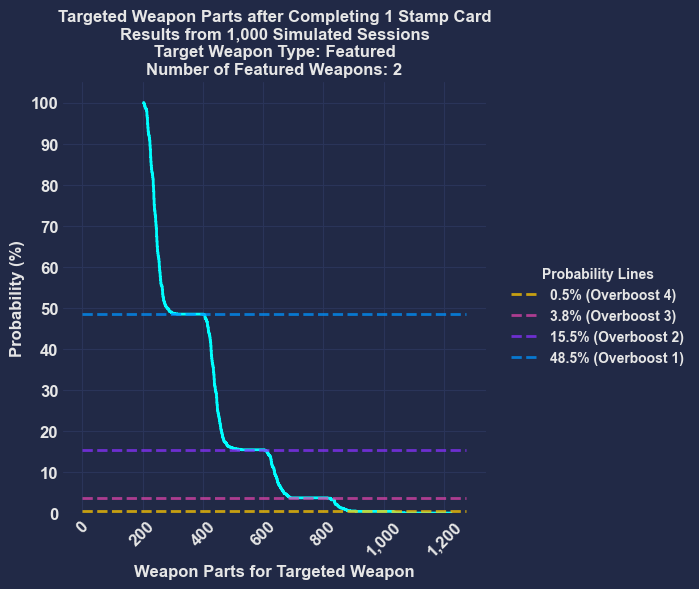

In [9]:
OUTCOME = "targeted_weapon_parts"
VALUES_OF_INTEREST = [400, 600, 800, 1_000]

viz_wrapper(gs=one_card_featured, column=OUTCOME, values=VALUES_OF_INTEREST)

# One Stamp Card -- Wishlisted Weapon Parts?

- Less than a 50-50 shot of getting a specific wishlist weapon at 5* 
- _This is not the same as the chance of getting __any__ wishlist weapon!_ Chances of ___any___ wishlist weapon are higher.
- Wishlisting only affects 5* chance, ___not___ 4* and 3* chance.
- Keep in mind that probability will be higher if only one weapon is featured!

In [10]:
one_card_wishlisted = stamp_analysis_wrapper(**stamp_analysis_inputs["one_card_wishlisted"])

one_card_wishlisted.run_sims(n_jobs=-1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2921.85it/s]


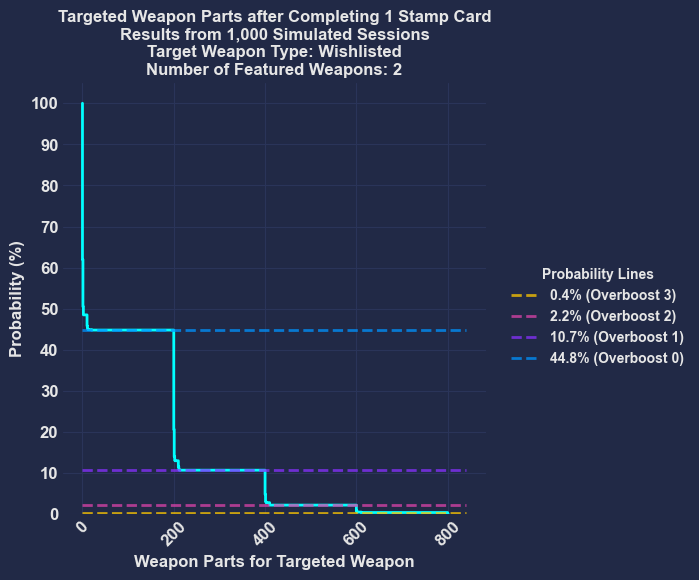

In [11]:
OUTCOME = "targeted_weapon_parts"
VALUES_OF_INTEREST = [200, 400, 600, 800]

viz_wrapper(gs=one_card_wishlisted, column=OUTCOME, values=VALUES_OF_INTEREST)

# Two Stamp Cards -- How many crystals?
- 39,000 for about a 50% of getting both costumes
- About 85% chance at 45,000 crystals (so much less than 72,000!)

In [12]:
two_cards_featured = stamp_analysis_wrapper(**stamp_analysis_inputs["two_cards_featured"])

two_cards_featured.run_sims(n_jobs=-1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1229.24it/s]


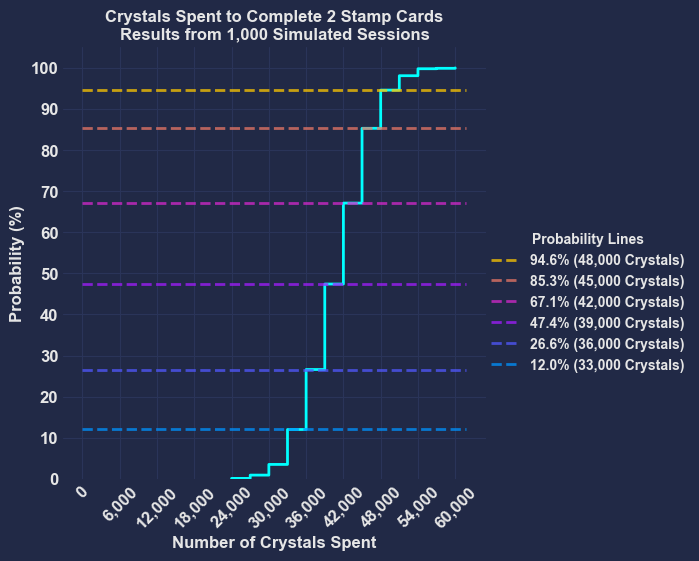

In [13]:
OUTCOME = "num_crystals_spent"
VALUES_OF_INTEREST = [33_000, 36_000, 39_000, 42_000, 45_000, 48_000]

viz_wrapper(gs=two_cards_featured, column=OUTCOME, values=VALUES_OF_INTEREST)

# Two Stamp Cards -- Targeted Featured Weapon Parts?

- Less than a 50% chance of OB2?! 

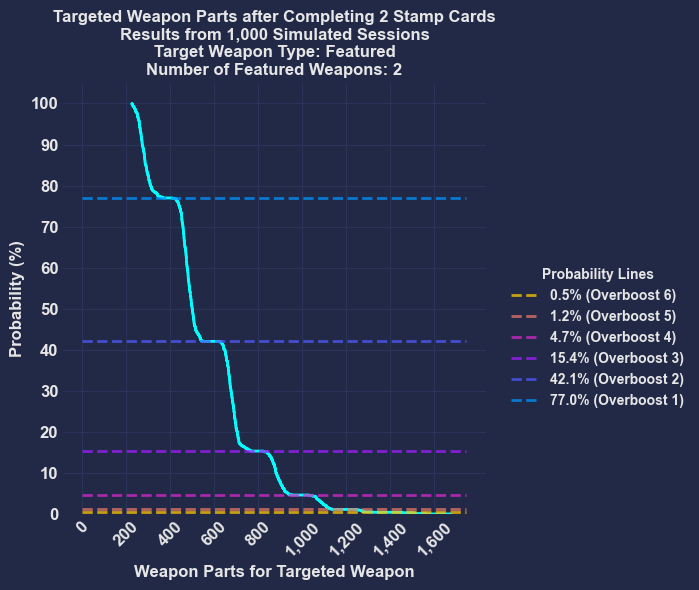

In [14]:
OUTCOME = "targeted_weapon_parts"
VALUES_OF_INTEREST = [400, 600, 800, 1_000, 1_200, 1_400]

viz_wrapper(gs=two_cards_featured, column=OUTCOME, values=VALUES_OF_INTEREST)

# Two Stamp Cards -- Wishlisted Weapon Parts?

- 70% chance of getting a specific wishlist weapon at 5*.

In [15]:
two_cards_wishlisted = stamp_analysis_wrapper(**stamp_analysis_inputs["two_cards_wishlisted"])

two_cards_wishlisted.run_sims(n_jobs=-1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1154.51it/s]


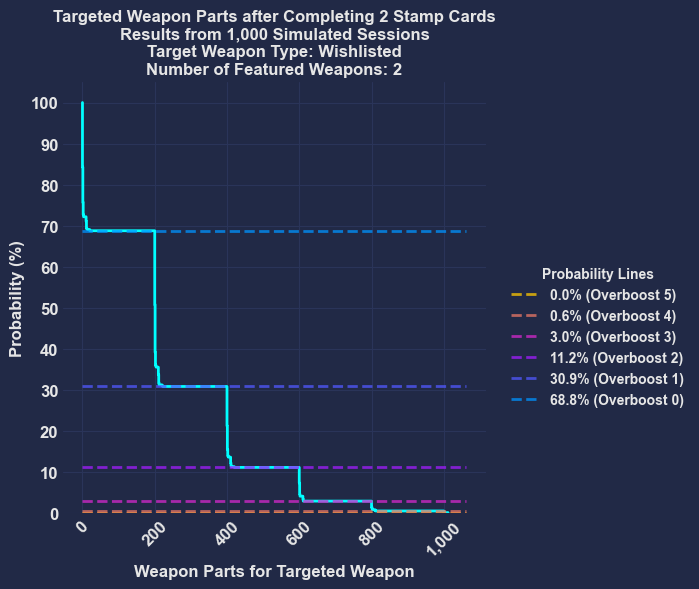

In [16]:
OUTCOME = "targeted_weapon_parts"
VALUES_OF_INTEREST = [200, 400, 600, 800, 1_000, 1_200]

viz_wrapper(gs=two_cards_wishlisted, column=OUTCOME, values=VALUES_OF_INTEREST)

# Questions for Limit Break banners:

How many crystals do I need to spend for an OB1 Weapon?

We'll ask the same questions for Ob3, Ob6, and OB10.

### _These simulations will assume that all stamp cards target one weapon!_

# Limit Break Banners -- Crystals for OB1

In [17]:
ob1 = ob_analysis_wrapper(1)

ob1.run_sims(n_jobs=-1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3162.84it/s]


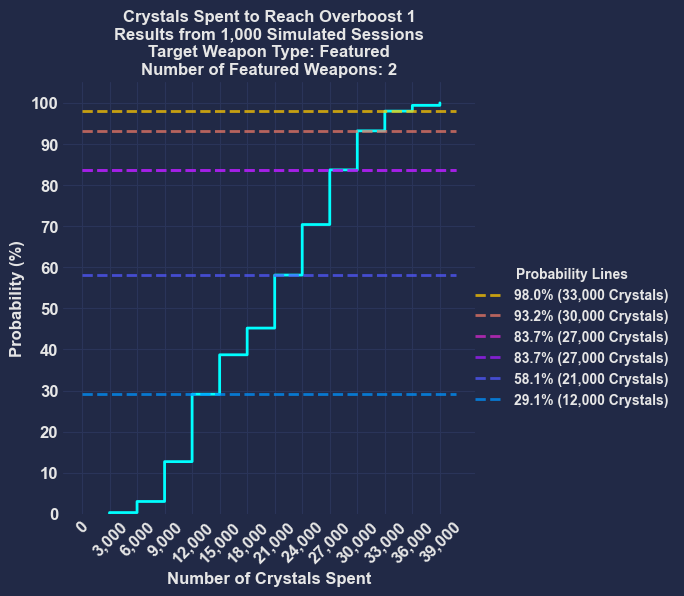

In [18]:
OUTCOME = "num_crystals_spent"
PROBS = [25, 50, 75, 80, 90, 95]
GS = ob1

viz_wrapper(gs=GS, column=OUTCOME, probs=PROBS)

# Limit Break Banners -- Crystals for OB3

In [19]:
ob3 = ob_analysis_wrapper(3)

ob3.run_sims(n_jobs=-1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1512.00it/s]


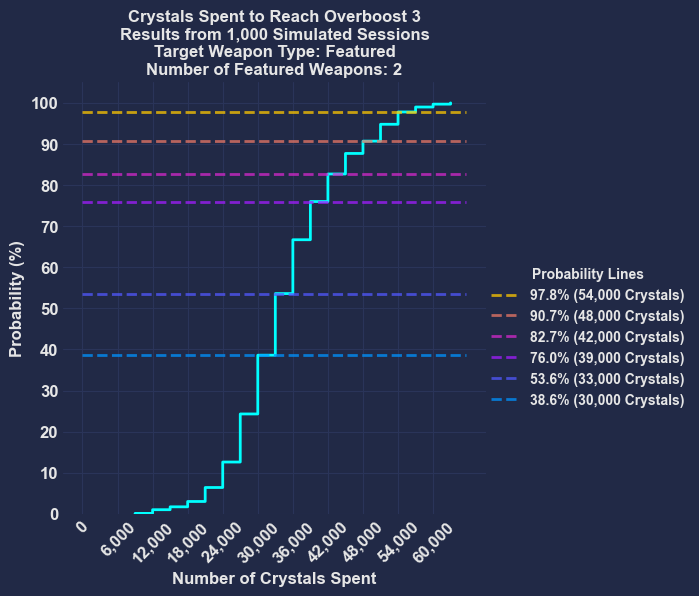

In [20]:
OUTCOME = "num_crystals_spent"
PROBS = [25, 50, 75, 80, 90, 95]
GS = ob3

viz_wrapper(gs=GS, column=OUTCOME, probs=PROBS)

# Limit Break Banners -- Crystals for OB6

In [21]:
ob6 = ob_analysis_wrapper(6)

ob6.run_sims(n_jobs=-1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 671.87it/s]


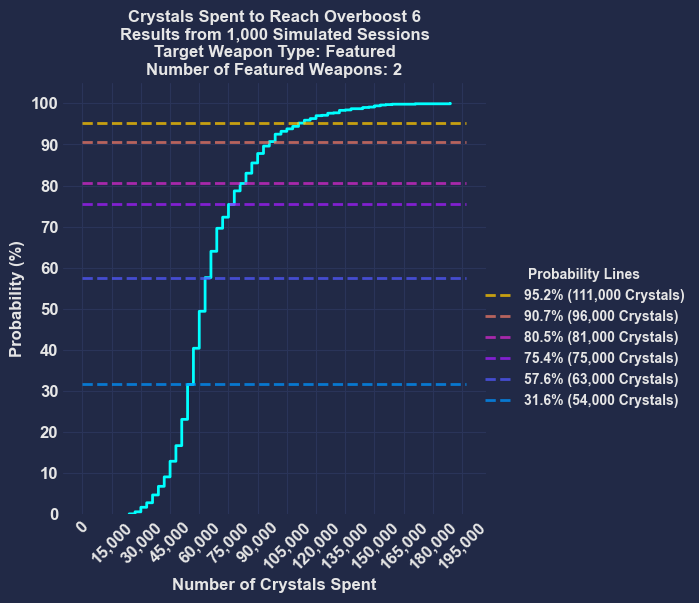

In [22]:
OUTCOME = "num_crystals_spent"
PROBS = [25, 50, 75, 80, 90, 95]
GS = ob6

viz_wrapper(gs=GS, column=OUTCOME, probs=PROBS)

# Limit Break Banners -- Crystals for OB10

In [23]:
ob10 = ob_analysis_wrapper(10)

ob10.run_sims(n_jobs=-1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.86it/s]


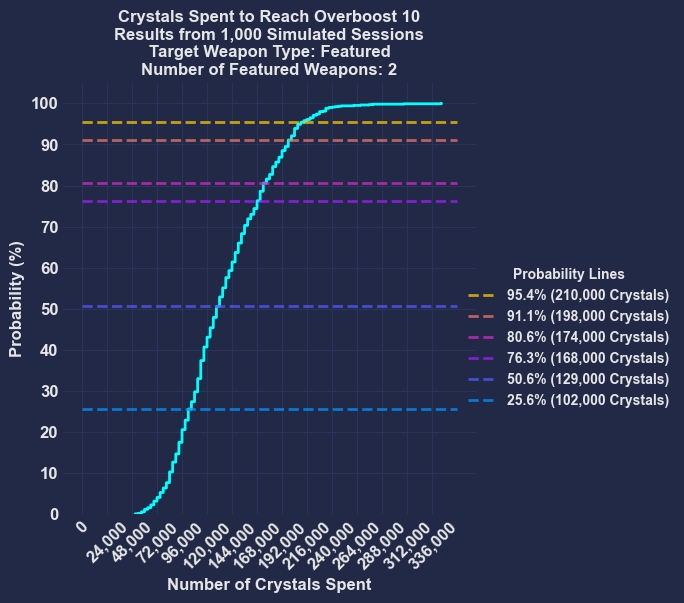

In [24]:
OUTCOME = "num_crystals_spent"
PROBS = [25, 50, 75, 80, 90, 95]
GS = ob10

viz_wrapper(gs=GS, column=OUTCOME, probs=PROBS)